# Analysis plan

* Load training data
* Make sure classes are evenly balanced, otherwise throw exception
* Load validation data
* Train model on training data
* Test model on validation data
* Move uncertain images from training and holdout sets to review folder
* Manually review uncertain images
* Adjust images as needed (delete bad images and move misclassified good images to training set)
* Calculate validation metrics for each occupation
* Create more training data if some occupations have bad metrics
* Repeat as needed
* Run final model against holdout data that hasn't been previously examined
* Calculate overall metrics and break out by gender and occupation
* Run final model against unlabeled data
* Save prediction for each image
* Calculate gender representation for each occupation

In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
#import polars as pl

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.cuda.is_available()

True

In [2]:
# Helper functions
def current_time_only() -> str:
    """Print current time at second precision without date."""
    return datetime.datetime.now().strftime('%H:%M:%S')

In [3]:
data_dir = 'H:/Photos/AI/'
batch_size = 40
classes = ('Female', 'Male')

# TODO: Count the number of images in each training folder and throw exception if imbalanced

# Load data in Pytorch format
transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to a fixed size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

train_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=transformations)
val_dataset = ImageFolder(os.path.join(data_dir, 'Holdout'), transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

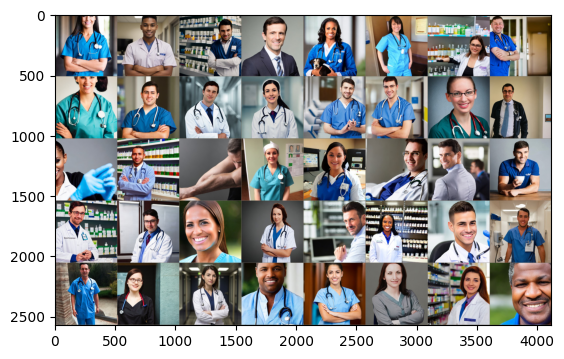

Female Male  Male  Male  Female Female Female Male  Female Male  Male  Female Male  Male  Female Male  Female Male  Male  Female Female Male  Male  Male  Male  Male  Female Female Male  Female Male  Male  Male  Female Female Male  Female Female Female Male 


In [4]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
    plt.imshow(img)
    plt.show()

# Get random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 125 * 125, 120)  # Corrected size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # For binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
train_epoch_loss = []
train_epoch_accuracy = []
validation_epoch_loss = []
validation_epoch_accuracy = []

for epoch in range(18):  # Increase the number of epochs
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        if i % 250 == 0:
            pass
            #print(f"Loading batch {i}/{len(train_loader)} ({datetime.datetime.now().strftime('%H:%M:%S')})")
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training loss and accuracy
    print(f'Epoch {epoch + 1}, Training loss: {running_loss / len(train_loader):.3f}')
    print(f'Epoch {epoch + 1}, Training accuracy: {100 * correct / total:.2f}%')
    train_epoch_loss.append(running_loss / len(train_loader))
    train_epoch_accuracy.append(100 * correct / total)

    # Validation loss and accuracy
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            if i % 250 == 0:
                pass
                #print(f"Validating batch {i+1}/{len(val_loader)} ({current_time_only()})")
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch + 1}, validation loss: {val_loss / len(val_loader):.3f}')
    print(f'Epoch {epoch + 1},  validation accuracy: {100 * correct / total:.2f}%')
    validation_epoch_loss.append(val_loss / len(val_loader))
    validation_epoch_accuracy.append(100 * correct / total)

print(f"Finished Training at {current_time_only()}")

Loading batch 0/500 (19:54:53)
Loading batch 250/500 (20:00:50)
Epoch 1, Training loss: 0.672
Epoch 1, Training accuracy: 57.92%
Validating batch 1/145 (20:06:24)
Validation loss: 0.637
Validation accuracy: 63.34%
Loading batch 0/500 (20:07:55)
Loading batch 250/500 (20:13:47)
Epoch 2, Training loss: 0.625
Epoch 2, Training accuracy: 64.65%
Validating batch 1/145 (20:19:39)
Validation loss: 0.584
Validation accuracy: 69.38%
Loading batch 0/500 (20:21:17)
Loading batch 250/500 (20:27:14)
Epoch 3, Training loss: 0.561
Epoch 3, Training accuracy: 70.28%
Validating batch 1/145 (20:32:36)
Validation loss: 0.549
Validation accuracy: 71.59%
Loading batch 0/500 (20:34:05)
Loading batch 250/500 (20:39:39)
Epoch 4, Training loss: 0.500
Epoch 4, Training accuracy: 75.25%
Validating batch 1/145 (20:45:08)
Validation loss: 0.512
Validation accuracy: 74.56%
Loading batch 0/500 (20:46:36)
Loading batch 250/500 (20:52:00)
Epoch 5, Training loss: 0.425
Epoch 5, Training accuracy: 80.05%
Validating batc

In [7]:
# Plot train and validation loss and accuracy by epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(train_epoch_accuracy, label="Training accuracy", color="#ffffb3")
axs[0].plot(validation_epoch_accuracy, label="Validation accuracy", color="#bebada")
axs[0].set_title("Accuracy")
axs[0].set(ylim=(0, 100))
axs[0].legend()

axs[1].plot(train_epoch_loss, label="Training loss", color="#ffffb3")
axs[1].plot(validation_epoch_loss, label="Validation loss", color="#bebada")
axs[1].set_title("Loss")
axs[1].set(ylim=(0, None))
axs[1].legend()

fig.suptitle("From-scratch model results", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

[63.341387642388675,
 69.38211943389713,
 71.59130134622023,
 74.55988954090438,
 76.13047980669658,
 78.44321712115982,
 77.83914394200897,
 77.09699689333793,
 78.2188470831895,
 77.06247842595789,
 76.83810838798757,
 78.25336555056955,
 78.44321712115982,
 78.32240248532965,
 78.68484639282016,
 79.23714187090093,
 79.91025198481188,
 80.16914049016223,
 80.10010355540214,
 79.97928891957197,
 79.996548153262,
 79.996548153262,
 80.04832585433206,
 80.04832585433206,
 80.04832585433206]

In [8]:
# This code is currently redundant with the last CV update in the training loop, but I have plans
# TODO: Save the predicted probability for each training image
# TODO: Save the predicted probability for each validation image
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        if i % 150 == 0:
            print(f"Validating batch {i+1}/{len(val_loader)} ({current_time_only()})")
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation loss: {val_loss / len(val_loader):.3f}')
print(f'Validation accuracy: {100 * correct / total:.2f}%')

# TODO: Analyze CV prediction accuracy by gender and occupation
# TODO: Move low-certainty images and high-certainty misses to a folder for human review

Validating batch 1/145 (01:03:16)
Validation loss: 1.377
Validation accuracy: 80.05%


In [9]:
# TODO: Automatically save model with timestamp in filename
torch.save(net.state_dict(), "pytorch_model_overfit.pth")

# Pre-trained model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load a pre-trained ResNet model
model_resnet = models.resnet50(pretrained=True)

# Freeze the layers except the final layer
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 2)  # For binary classification

# Move model_resnet to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimize the parameters of the final layer
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

resnet_train_epoch_loss = []
resnet_train_epoch_accuracy = []
resnet_validation_epoch_loss = []
resnet_validation_epoch_accuracy = []

# Train the model
num_epochs = 2  # Adjust based on your need
for epoch in range(num_epochs):
    model_resnet.train()
    print(f"Epoch {epoch+1} initiated ({current_time_only()})")
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        if i % 100 == 0:
            print(f"Training batch {i+1}/{len(train_loader)} ({current_time_only()})")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    print("****************")
    print(f'Epoch {epoch + 1}:')
    print(f'    Training loss: {running_loss / len(train_loader):.3f}')
    print(f'    Training accuracy: {100 * correct_train / total_train:.2f}%')
    print("****************")
    resnet_train_epoch_loss.append(running_loss / len(train_loader))
    resnet_train_epoch_accuracy.append(correct_train / total_train)
    
    # # Validation
    pass
    # model_resnet.eval()
    # val_loss = 0.0
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     print(f"Validation started ({current_time_only()})")
    #     for inputs, labels in val_loader:
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         outputs = model_resnet(inputs)
    #         loss = criterion(outputs, labels)
    #         val_loss += loss.item()
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()
    # 
    # print(f'Epoch {epoch+1}/{num_epochs}, '
    #       f'Train Loss: {running_loss/len(train_loader):.3f}, '
    #       f'Validation Loss: {val_loss/len(val_loader):.3f}, '
    #       f'Validation Accuracy: {100 * correct / total:.2f}%')

print(f'Finished Training ({current_time_only()})')

Training initiated (10:20:07)
Training batch 1/500 (10:20:08)
Training batch 101/500 (10:30:05)
Training batch 201/500 (10:39:16)
Training batch 301/500 (10:48:26)
Training batch 401/500 (10:58:05)
Epoch 1)
Training loss: 0.268
Training accuracy: 90.21%
Training initiated (11:07:11)
Training batch 1/500 (11:07:11)
Training batch 101/500 (11:17:13)
Training batch 201/500 (11:26:49)
Training batch 301/500 (11:36:35)
